In [1]:
%matplotlib inline

In [2]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.metrics import auc

In [3]:
from utils import annotate_correctness
import analyse

# Read and prepare data

In [6]:
# idpep_fn = "OR20070924_S_mix7_02-10_xtandem_pmt15ppm_target_decoy_merged_IDPEP_pp_v2_fido.json"
percolator_fn = "OR20070924_S_mix7_02-10_comet_pmt15ppm_o1_percolator_fido_F0.05_t0.05_protein_target_pout_psms.json"
percolator_decoy_fn = "OR20070924_S_mix7_02-10_comet_pmt15ppm_o1_percolator_fido_F0.05_t0.05_protein_decoy_pout_psms.json"

In [7]:
data = {}
for key, fn in [
#     ("IDPEP", idpep_fn),
    ("Percolator", percolator_fn)
]:
    with open(fn) as f:
        data[key] = json.load(f)
    data[key] = annotate_correctness(data[key], protein_key="accession")

In [8]:
with open(percolator_decoy_fn) as f:
    decoy = json.load(f)
decoy = annotate_correctness(decoy, protein_key="accession")

# Stats

In [9]:
print("key", "Number of Proteins", "Number of unique proteins", sep="\t")
for key, d in data.items():
    print(key, analyse.n_psms(d), analyse.n_unique_peptides(d, protein_key="accession"), sep="\t")

key	Number of Proteins	Number of unique proteins
Percolator	700	700


# Number of correct identifications

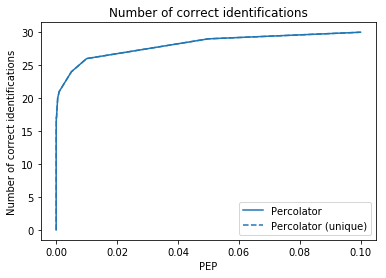

In [10]:
for i, (key, d) in enumerate(data.items()):
    thresh_list, n_correct_ident = analyse.n_correct_identifications(d)
    _, n_unique_ident = analyse.n_unique_correct_identifications(d, protein_key="accession")
    plt.plot(thresh_list, n_correct_ident, label=key, color="C{}".format(i))
    plt.plot(thresh_list, n_unique_ident, label="{} (unique)".format(key), color="C{}".format(i), ls="--")
plt.title("Number of correct identifications")
plt.xlabel("PEP")
plt.ylabel("Number of correct identifications")
plt.legend();

# PEP distributions

In [12]:
# fig, axarr = plt.subplots(1, 2, figsize=(20, 5))
# for i, (key, d) in enumerate(data.items()):
#     correct_peps = analyse.reduce_to_list(analyse.correct_psms(d))
#     incorrect_peps = analyse.reduce_to_list(analyse.incorrect_psms(d))
#     axarr[i].hist(correct_peps, bins=50, color="C{}".format(i), label="{} (correct)".format(key), alpha=0.3)
#     axarr[i].hist(incorrect_peps, bins=50, color="C{}".format(i), label="{} (incorrect)".format(key), histtype="step")
#     axarr[i].set_xlabel("PEP")
#     axarr[i].set_ylabel("Count")
#     axarr[i].legend()
# decoy_peps = analyse.reduce_to_list(decoy)
# plt.suptitle("PEP distributions");

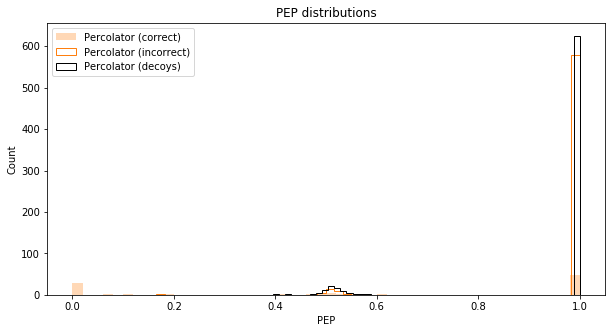

In [13]:
plt.figure(figsize=(10, 5))
correct_peps = analyse.reduce_to_list(analyse.correct_psms(data["Percolator"]))
incorrect_peps = analyse.reduce_to_list(analyse.incorrect_psms(data["Percolator"]))
decoy_peps = analyse.reduce_to_list(decoy)
plt.hist(correct_peps, bins=50, color="C1", label="Percolator (correct)", alpha=0.3)
plt.hist(incorrect_peps, bins=50, color="C1", label="Percolator (incorrect)", histtype="step")
plt.hist(decoy_peps, bins=50, color="k", label="Percolator (decoys)", histtype="step")
plt.legend()
plt.xlabel("PEP")
plt.ylabel("Count")
plt.title("PEP distributions");

# ROC curves

In [14]:
imp_pep = [0.01, 0.05]

In [15]:
pep_inds = [
    analyse._DEFAULT_PEP_THRESH_LIST.index(pep)
    for pep in imp_pep
]

In [16]:
pep_inds

[9, 10]

In [17]:
percolator_joined = data["Percolator"] + decoy

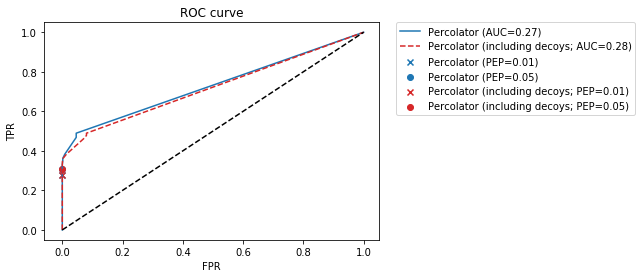

In [18]:
for i, (key, d) in enumerate(data.items()):
    thresh_list, tp_rates, fp_rates = analyse.roc_curve(d)
    plt.plot(fp_rates, tp_rates, label="{} (AUC={:.2f})".format(key, auc(tp_rates, fp_rates)), color="C{}".format(i))
    for pep, ind, marker in zip(imp_pep, pep_inds, ["x", "o"]):
        plt.scatter(fp_rates[ind], tp_rates[ind], marker=marker, label="{} (PEP={})".format(key, pep), color="C{}".format(i))
thresh_list, tp_rates, fp_rates = analyse.roc_curve(percolator_joined)
plt.plot(fp_rates, tp_rates, label="Percolator (including decoys; AUC={:.2f})".format(auc(tp_rates, fp_rates)), color="C3", ls="--")
for pep, ind, marker in zip(imp_pep, pep_inds, ["x", "o"]):
        plt.scatter(fp_rates[ind], tp_rates[ind], marker=marker, label="Percolator (including decoys; PEP={})".format(pep), color="C3")
plt.plot([0, 1], [0, 1], ls="--", color="k")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# Precision-Recall curves

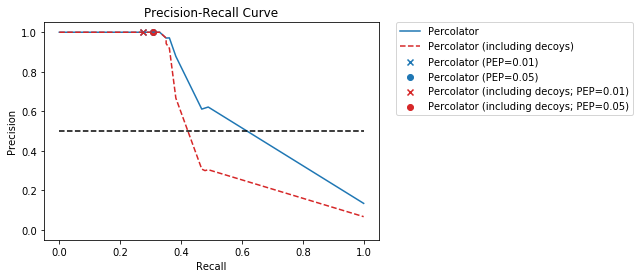

In [19]:
for i, (key, d) in enumerate(data.items()):
    thresh_list, precision, recall = analyse.precision_recall_curve(d)
    plt.plot(recall, precision, label=key)
    for pep, ind, marker in zip(imp_pep, pep_inds, ["x", "o"]):
        plt.scatter(recall[ind], precision[ind], marker=marker, label="{} (PEP={})".format(key, pep), color="C{}".format(i))
thresh_list, precision, recall = analyse.precision_recall_curve(percolator_joined)
for pep, ind, marker in zip(imp_pep, pep_inds, ["x", "o"]):
        plt.scatter(recall[ind], precision[ind], marker=marker, label="Percolator (including decoys; PEP={})".format(pep), color="C3")
plt.plot(recall, precision, label="Percolator (including decoys)", color="C3", ls="--")
plt.plot([0, 1], [0.5, 0.5], ls="--", color="k")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim(0 - 0.05, 1 + 0.05)
plt.title("Precision-Recall Curve")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# Actual vs computed PEP

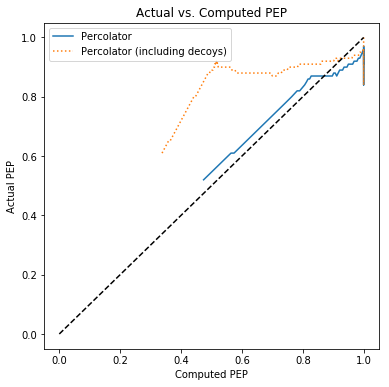

In [20]:
plt.figure(figsize=(6, 6))
for i, (key, d) in enumerate(data.items()):
    actual, computed = analyse.actual_vs_computed_pep(d)
    plt.plot(computed, actual, label=key)
actual, computed = analyse.actual_vs_computed_pep(percolator_joined)
plt.plot(computed, actual, label="Percolator (including decoys)", color="C1", ls=":")
plt.plot([0, 1], [0, 1], color="k", ls="--")
plt.xlabel("Computed PEP")
plt.ylabel("Actual PEP")
plt.xlim(0 - 0.05, 1 + 0.05)
plt.ylim(0 - 0.05, 1 + 0.05)
plt.title("Actual vs. Computed PEP")
plt.legend();